<a href="https://colab.research.google.com/github/anihab/dnaTokenization/blob/main/results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import pandas as pd
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [188]:
# define color scheme
colors = ['#AD000E', '#D6382B', '#FF5E49', '#FF8269', '#FFA789']
colors2 = ['#AD000E', '#D6382B', '#FFA15A', '#FF8269', '#FFA789']
colors_heatmap = ['#FFA789', '#FF8269', '#FF5E49', '#D6382B', '#AD000E']
model_color_map = {'DNABERT-1 (6-mer)': '#AD000E', 'DNABERT-2': '#D6382B', 'GPT2': '#FFA15A', 'NT 500M 1000G': '#FF8269', 'HyenaDNA (1k)': '#FFA789'}

##**Load and Process Data**



In [190]:
# get our results
df = pd.read_csv('/content/drive/MyDrive/tokenization/data/finetune/results.csv')
df.head()

,model,task,task_category,task_benchmark,replicate_number,accuracy,f1,mcc,sequence_length,epoch
0,DNABERT-1 (6-mer),enhancers,Regulatory (human),Nucleotide Transformer,1.0,0.852310,0.852189,0.704499,200.0,4.0
1,DNABERT-1 (6-mer),enhancers_types,Regulatory (human),Nucleotide Transformer,1.0,0.767729,0.738276,0.630650,200.0,4.0
2,DNABERT-1 (6-mer),splice_sites_all,Splice Sites (human),Nucleotide Transformer,1.0,0.980667,0.980643,0.971021,600.0,5.0
3,DNABERT-1 (6-mer),splice_sites_acceptors,Splice Sites (human),Nucleotide Transformer,1.0,0.970694,0.970694,0.941455,400.0,5.0
4,DNABERT-1 (6-mer),splice_sites_donor,Splice Sites (human),Nucleotide Transformer,1.0,0.977242,0.977241,0.954496,400.0,5.0


In [191]:
# nt_tasks list
nt_tasks = [
    'enhancers', 'enhancers_types', 'splice_sites_all', 'splice_sites_acceptors',
    'splice_sites_donor', 'H3', 'H3K14ac', 'H3K36me3', 'H3K4me1', 'H3K4me2',
    'H3K4me3', 'H3K79me3', 'H3K9ac', 'H4', 'H4ac', 'prom_300_all',
    'prom_300_notata', 'prom_300_tata'
]

# separated by benchmark
gue = df[df['task_benchmark'] == 'GUE']
gb = df[df['task_benchmark'] == 'Genomic Benchmark']
ntb = df[df['task'].isin(nt_tasks)]

In [192]:
# phage results
phage_df = pd.read_csv('/content/drive/MyDrive/tokenization/data/finetune/phage_results.csv')
phage_df.head()

,model,task,task_category,task_benchmark,replicate_number,accuracy,f1,mcc,epoch
0,HyenaDNA (4k),phage,Phage Identification,Phage Identification,1,0.883957,0.883958,0.767902,100.0
1,HyenaDNA (4k),phage,Phage Identification,Phage Identification,2,0.898480,0.898482,0.796958,100.0
2,HyenaDNA (4k),phage,Phage Identification,Phage Identification,3,0.896461,0.896462,0.792920,100.0
3,HyenaDNA (4k),phage,Phage Identification,Phage Identification,4,0.889872,0.889869,0.779729,100.0
4,HyenaDNA (4k),phage,Phage Identification,Phage Identification,5,0.895499,0.895499,0.790987,100.0


In [193]:
# get all average metrics across number of replications
average_metrics = df.groupby(['model', 'task_category']).agg({'mcc': ['mean', 'std']})
average_metrics.columns = ['mean', 'std']
average_metrics['mean'] = average_metrics['mean'].round(2)
average_metrics['std'] = average_metrics['std'].round(3)
average_metrics.reset_index(inplace=True)
average_metrics.head()

,model,task_category,mean,std
0,DNABERT-1 (6-mer),EMP (yeast),0.49,0.163
1,DNABERT-1 (6-mer),Regulatory (human),0.66,0.168
2,DNABERT-1 (6-mer),Regulatory (mouse),0.24,0.077
3,DNABERT-1 (6-mer),Species Classfication,0.82,0.008
4,DNABERT-1 (6-mer),Splice Sites (human),0.93,0.051


In [194]:
# get reported results
reported = pd.read_csv('/content/drive/MyDrive/tokenization/data/finetune/reported.csv')
reported['mcc'] = reported['matthews_correlation'] / 100

# merge self-reported results with our averaged results and results reported by other teams
ours = average_metrics
ours['reported_by'] = 'us'
merged_df = pd.merge(reported, ours, how='outer')
merged_df.head()

,model,reported_by,task,task_category,task_benchmark,accuracy,f1,matthews_correlation,mcc,mean,std
0,DNABERT-1 (6-mer),dnabert,H3,EMP (yeast),GUE,NaN,NaN,73.10,0.7310,NaN,NaN
1,DNABERT-1 (6-mer),dnabert,H3K14ac,EMP (yeast),GUE,NaN,NaN,40.06,0.4006,NaN,NaN
2,DNABERT-1 (6-mer),dnabert,H3K36me3,EMP (yeast),GUE,NaN,NaN,47.25,0.4725,NaN,NaN
3,DNABERT-1 (6-mer),dnabert,H3K4me1,EMP (yeast),GUE,NaN,NaN,41.44,0.4144,NaN,NaN
4,DNABERT-1 (6-mer),dnabert,H3K4me2,EMP (yeast),GUE,NaN,NaN,32.37,0.3237,NaN,NaN


##**Full Results**

*  **Bar chart:** Mean MCC results for each task category by model, with SD bars
*  **Heatmap:** Mean MCC results vs. sequence length by model

In [195]:
average_metrics = pd.concat([average_metrics,
                      pd.DataFrame([{'model': 'HyenaDNA (1k)', 'task_category': 'Splice Sites (human)', 'mean': 0.81, 'std': 0.01}])],
                     ignore_index=True)

# bar chart
bar = px.bar(average_metrics[average_metrics['task_category'] != 'Covid Variants (virus)'],
             x='task_category', y='mean',
             color='model', color_discrete_map=model_color_map,
             labels={
                     "task_category": "Task Category",
                     "mean": "MCC"
                 },
             barmode='group',
             text_auto=True,
             error_x='std', error_y='std',
             title='Mean MCC for Task Categories by Model',
             template='plotly_white')
bar.update_traces(insidetextanchor='start')
bar.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
bar.show()

In [196]:
filtered = df.groupby(['model', 'task', 'sequence_length']).agg({'mcc': ['mean', 'std']})
filtered.columns = ['mean', 'std']
filtered['mean'] = filtered['mean'].round(2)
filtered['std'] = filtered['std'].round(3)
filtered.reset_index(inplace=True)

filtered = pd.concat([filtered,
                      pd.DataFrame([{'model': 'HyenaDNA (1k)', 'task': 'splice_sites_all', 'sequence_length': 600, 'mean': 0.81, 'std': 0.01}])],
                     ignore_index=True)
filtered = pd.concat([filtered,
                      pd.DataFrame([{'model': 'HyenaDNA (1k)', 'task': 'splice_sites_donors', 'sequence_length': 400, 'mean': 0.81, 'std': 0.01}])],
                     ignore_index=True)
filtered = filtered[(filtered['task'] != 'covid') & (filtered['task'] != 'dummy_mouse_enhancers')]

# pivot the DataFrame to create the matrix format for the heatmap
pivot_filtered = filtered.pivot_table(index='model', columns='sequence_length', values='mean')

# create the heatmap
fig = px.imshow(pivot_filtered,
                labels={'x': 'Sequence Length (# of Nucleotides)', 'y': 'Model', 'color': 'MCC'},
                title='Mean MCC vs. Sequence Length by Model',
                zmin=0, zmax=1,  # Set the color scale range
                color_continuous_scale=colors_heatmap,
                template='plotly_white')

fig.show()

# # line plot
# line = px.scatter(filtered[(filtered['task'] != 'covid') & (filtered['task'] != 'dummy_mouse_enhancers')],
#              x='sequence_length', y='mean', trendline='ols',
#              color='model', color_discrete_map=model_color_map,
#              labels={
#                      "sequence_length": "Sequence Length (# of Nucleotides)",
#                      "mean": "MCC"
#                  },
#              title='Mean MCC vs. Sequence Length by Model with Line of Best Fit')
# line.update_layout(legend=dict(
#     orientation="h",
#     yanchor="bottom",
#     y=1.02,
#     xanchor="right",
#     x=1
# ))
# line.show()

##**Bar Charts by Task**

*   Mean results by task for each model, with SD bars

In [197]:
task = 'H3'
statistic = 'mcc'

filtered = df.groupby(['model', 'task', 'task_category']).agg({statistic: ['mean', 'std']})
filtered.columns = ['mean', 'std']
filtered['mean'] = filtered['mean'].round(2)
filtered.reset_index(inplace=True)

bar = px.bar(filtered[filtered['task'] == task],
             x='mean', y='model', color='model',
             color_discrete_map=model_color_map,
             text_auto=True,
             error_x='std', error_y='std',
             title=task,
             template='plotly_white')

bar.update_layout(title_x=0.5,
                  showlegend=False,
                  xaxis=dict(showline=True, linecolor='black', title=''),
                  yaxis=dict(showline=True, linecolor='black', title=''),
                  )
bar.update_traces(insidetextanchor='start', textfont_color='white', textfont_size=14)
bar.update_traces(marker_showscale=False)

bar.update_layout(bargap=0.1)
bar.update_xaxes(range = [0,1])
bar.show()

In [150]:
def filter_by_category(category, title):
  statistic = 'mcc'

  filtered = df[df['task_category'] == category]
  filtered = filtered.groupby(['model', 'task']).agg({statistic: ['mean', 'std']})
  filtered.columns = ['mean', 'std']
  filtered['mean'] = filtered['mean'].round(2)
  filtered['std'] = filtered['std'].round(3)
  filtered.reset_index(inplace=True)

  fig = px.bar(filtered,
              x='task', y='mean',
              color='model', color_discrete_map=model_color_map,
              labels={
                      'mean': 'MCC',
                      'task': "Task",
                  },
              barmode='group',
              text_auto=True,
              error_x='std', error_y='std',
              title=title,
              template='plotly_white')
  fig.update_traces(insidetextanchor='start')
  fig.update_layout(legend=dict(
      orientation="h",
      yanchor="bottom",
      y=1.02,
      xanchor="right",
      x=1
  ))
  fig.show()

In [151]:
filter_by_category('EMP (yeast)', 'Mean MCC for Epigenetic Mark Prediction Tasks by Model')

##**Bar Charts by Benchmark**

In [217]:
def filter_by_benchmark(benchmark, statistic):
  if benchmark == 'GUE':
    filtered = gue.groupby(['model', 'task_category']).agg({statistic: ['mean', 'std']})
  elif benchmark == 'NT':
    filtered = ntb.groupby(['model', 'task_category']).agg({statistic: ['mean', 'std']})
  else:
    filtered = gb.groupby(['model', 'task_category']).agg({statistic: ['mean', 'std']})

  filtered.columns = ['mean', 'std']
  filtered['mean'] = filtered['mean'].round(2)
  filtered.reset_index(inplace=True)

  fig = px.bar(filtered,
               x='task_category', y='mean',
               color='model', color_discrete_map=model_color_map,
               labels={"task_category": "Task Category", "mean": "MCC"},
               barmode='group',
               text_auto=True,
               error_x='std', error_y='std',
               title='Mean MCC for ' + benchmark + ' Task Categories by Model',
               template='plotly_white')
  fig.update_traces(insidetextanchor='start')
  fig.update_layout(legend=dict(
      orientation="h",
      yanchor="bottom",
      y=1.02,
      xanchor="right",
      x=1
  ))
  fig.show()

In [218]:
filter_by_benchmark('GUE', 'mcc')
filter_by_benchmark('NT', 'mcc')
filter_by_benchmark('Genomic Benchmark', 'mcc')

In [221]:
def benchmark_mean(benchmark, statistic):
  if benchmark == 'Nucleotide Transformer':
    filtered = ntb.groupby(['model']).agg({statistic: ['mean', 'std']})
  elif benchmark == 'GUE':
    filtered = gue.groupby(['model']).agg({statistic: ['mean', 'std']})
  else:
    filtered = gb.groupby(['model']).agg({statistic: ['mean', 'std']})

  filtered.columns = ['mean', 'std']
  filtered['mean'] = filtered['mean'].round(2)
  filtered.reset_index(inplace=True)

  bar = px.bar(filtered,
              x='mean', y='model', color='model',
              color_discrete_map=model_color_map,
              text_auto=True,
              title=benchmark,
              template='plotly_white')

  bar.update_layout(title_x=0.5,
                    showlegend=False,
                    xaxis=dict(showline=True, linecolor='black', title='MCC'),
                    yaxis=dict(showline=True, linecolor='black', title=''),
                    )
  bar.update_traces(insidetextanchor='start', textfont_color='white', textfont_size=14)

  bar.update_layout(bargap=0.1)
  bar.update_xaxes(range = [0,1])
  bar.show()

In [222]:
benchmark_mean('Nucleotide Transformer', 'mcc')
benchmark_mean('GUE', 'mcc')
benchmark_mean('Genomic Benchmark', 'mcc')

##**Violin Plots**

*  show results for tasks that had a large standard deviation i.e., more variability than we expected.

<ipython-input-223-6dcdec200cee>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




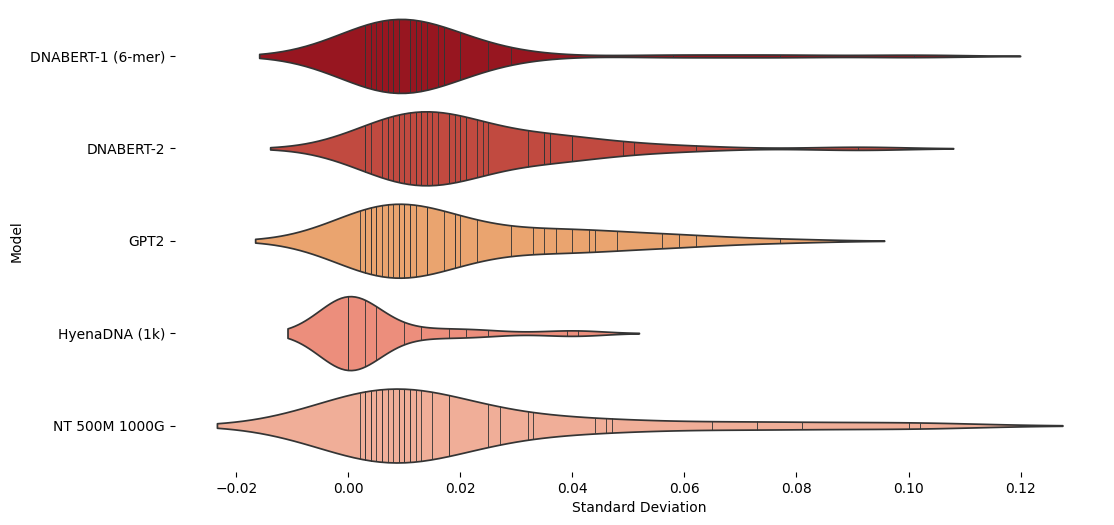

In [223]:
filtered = df.groupby(['model', 'task']).agg({statistic: ['mean', 'std']})
filtered.columns = ['mean', 'std']
filtered['mean'] = filtered['mean'].round(2)
filtered['std'] = filtered['std'].round(3)
filtered.reset_index(inplace=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(filtered['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(filtered, x='std', y='model', inner='stick', palette=colors2)
sns.despine(top=True, right=True, bottom=True, left=True)

plt.xlabel('Standard Deviation')
plt.ylabel('Model')

plt.show()

In [224]:
fig = px.violin(df[(df['model'] == 'DNABERT-2') & (df['task'] == 'H3K4me3')],
                x='mcc', labels={'mcc': 'MCC'},
                points='all',
                box=True,
                color='model',
                color_discrete_map=model_color_map,
                title='DNABERT2 H3K4me3 Task MCC Variation by Replication',
                template='plotly_white')
fig.update_traces(pointpos=0)
fig.update_layout(showlegend=False)
fig.show()

##**Scatter Plot: Matthews Correlation Self Reported vs. Experimental Results**

*   x-axis - self reported
*   y-axis - measured by us or other publications
*   color the dots by category

In [ ]:
def mcc_comparison(model, title):
  # filter data to single model
  filtered_df = merged_df[merged_df['model'] == model]
  self_reported = filtered_df[filtered_df['reported_by'] == 'dnabert']
  other_reported = filtered_df[filtered_df['reported_by'] != 'dnabert']

  # merge 'self_reported' and 'other_reported' to align the rows
  aligned_df = pd.merge(self_reported[['reported_by', 'task', 'task_category', 'mcc']],
                        other_reported[['reported_by', 'task', 'task_category', 'mcc']],
                        on=['task', 'task_category'],
                        suffixes=('_self', '_other'))

  # map reported category to opacity values
  opacity_mapping = {'NT': 0.5, 'us': 1.0}
  aligned_df['opacity'] = aligned_df['reported_by_other'].map(opacity_mapping)

  # create a scatter plot
  fig = px.scatter(aligned_df,
                  x='mcc_self',
                  y='mcc_other',
                  color='task_category',
                  color_discrete_sequence=colors,
                  opacity=aligned_df['opacity'],
                  labels={
                      "mcc_self": "Self-Reported MCC",
                      "mcc_other": "Mean Experimental MCC",
                  },
                  hover_data=['task', 'reported_by_other'],
                  title=title)
  fig.update_traces(marker={'size': 15})
  fig.show()

mcc_comparison('DNABERT-1 (6-mer)', 'DNABERT-1 MCC Comparison (Experimental Results vs. Self-Reported)')
mcc_comparison('DNABERT-2', 'DNABERT-2 MCC Comparison (Experimental Results vs. Self-Reported)')
mcc_comparison('NT 500M 1000G', 'NT 500M 1000G MCC Comparison (Experimental Results vs. Self-Reported)')
mcc_comparison('HyenaDNA', 'HyenaDNA MCC Comparison (Experimental Results vs. Self-Reported)')

##**Phage Results**

In [ ]:
statistic = 'mcc'

filtered = phage_df.groupby(['model', 'task']).agg({statistic: ['mean', 'std']})
filtered.columns = ['mean', 'std']
filtered['mean'] = filtered['mean'].round(2) * 100
filtered['std'] = filtered['std'].round(2) * 100
filtered.reset_index(inplace=True)

dnabert2 = pd.DataFrame({'model': 'DNABERT-2', 'task': 'phage', 'mean': 90.6, 'std': 0}, index=[0])
dnabert1 = pd.DataFrame({'model': 'DNABERT-1 (6-mer)', 'task': 'phage', 'mean': 63, 'std': 0}, index=[0])
nt500 = pd.DataFrame({'model': 'NT 500M 1000G', 'task': 'phage', 'mean': 62.5, 'std': 0}, index=[0])

filtered = pd.concat([filtered, dnabert2, dnabert1, nt500], ignore_index=True)

fig = px.bar(filtered, x='task', y='mean',
             color='model', color_discrete_map=model_color_map,
             labels={
                     "mean": "Percentage",
                     "task": "Task",
                 },
             barmode='group',
             text_auto=True,
             error_x='std', error_y='std',
             title='Mean MCC for Phage Identification Task by Model')
fig.update_traces(insidetextanchor='start')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()